# Week 4 Quiz

Task:

Given data about an instrumental variable, find the effect. X is the treatment, W the confounder, Y the outcome, and Z the instrument. Use homework_4.1.csv. 

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [3]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
data = pd.read_csv('homework_4.1.csv')
print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head(10))
print("\nData info:")
print(data.info())
print("\nSummary statistics:")
print(data.describe())


Data shape: (5000, 5)

First few rows:
   Unnamed: 0  Z         W         X         Y
0           0  0 -0.155644 -0.496971  0.282484
1           1  1  0.529539  2.284240  4.740596
2           2  1  0.910514  0.872232  3.449569
3           3  1 -0.705476  2.157260  3.002531
4           4  0 -0.590874 -0.386730 -1.848796
5           5  1  0.533635  0.981649  1.866566
6           6  0  1.293241 -0.041748  2.427692
7           7  0  0.243445 -0.113452 -0.177196
8           8  0 -0.714465 -0.129564  1.673641
9           9  1 -1.548130  0.126844 -0.379818

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5000 non-null   int64  
 1   Z           5000 non-null   int64  
 2   W           5000 non-null   float64
 3   X           5000 non-null   float64
 4   Y           5000 non-null   float64
dtypes: float64(3), int64(2)
memory usa

In [4]:
# Extract variables
Z = data['Z'].values  # Instrument
W = data['W'].values  # Confounder
X = data['X'].values  # Treatment
Y = data['Y'].values  # Outcome

print(f"\nVariable ranges:")
print(f"Z (instrument): {Z.min():.3f} to {Z.max():.3f}")
print(f"W (confounder): {W.min():.3f} to {W.max():.3f}")
print(f"X (treatment): {X.min():.3f} to {X.max():.3f}")
print(f"Y (outcome): {Y.min():.3f} to {Y.max():.3f}")

# Check the unique values of Z (should be binary for a valid instrument)
print(f"\nUnique values of Z (instrument): {np.unique(Z)}")
print(f"Distribution of Z: {np.bincount(Z.astype(int))}")


Variable ranges:
Z (instrument): 0.000 to 1.000
W (confounder): -3.303 to 4.783
X (treatment): -3.404 to 4.694
Y (outcome): -7.033 to 10.082

Unique values of Z (instrument): [0 1]
Distribution of Z: [2493 2507]


## Exploratory Data Analysis

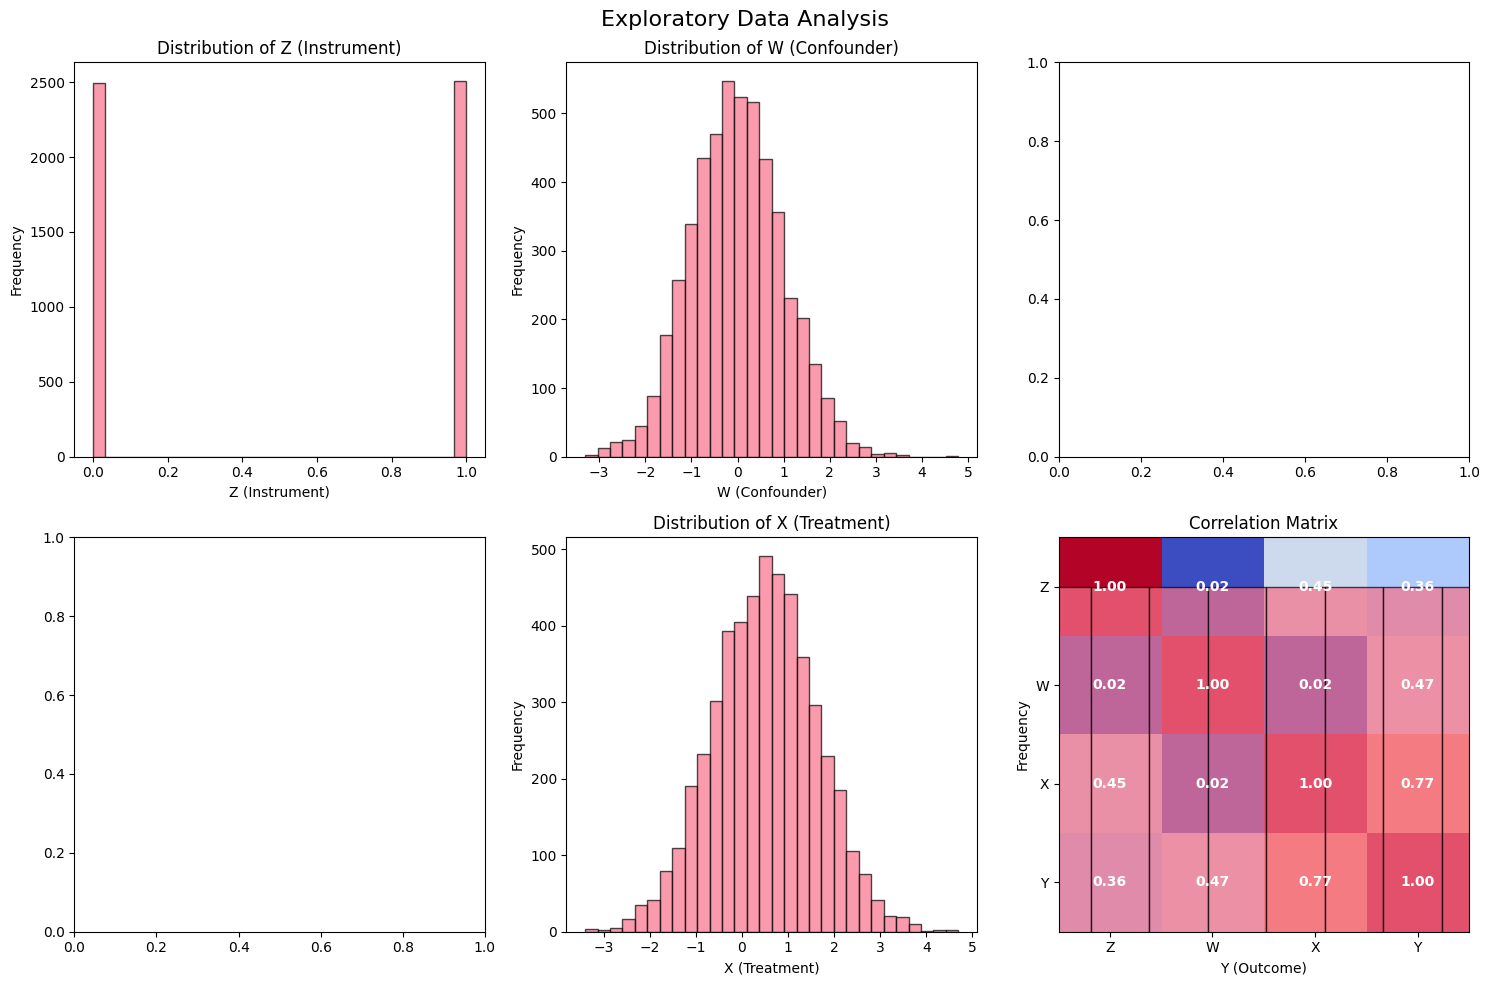


Correlation Matrix:
          Z         W         X         Y
Z  1.000000  0.024584  0.451929  0.357419
W  0.024584  1.000000  0.017083  0.473979
X  0.451929  0.017083  1.000000  0.765113
Y  0.357419  0.473979  0.765113  1.000000


In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16)

# Plot distributions
for i, (var, name) in enumerate(zip([Z, W, X, Y], ['Z (Instrument)', 'W (Confounder)', 'X (Treatment)', 'Y (Outcome)'])):
    if i < 4:
        row, col = i // 2, i % 2 if i < 2 else (i % 2) + 1
        axes[row, col].hist(var, bins=30, alpha=0.7, edgecolor='black')
        axes[row, col].set_title(f'Distribution of {name}')
        axes[row, col].set_xlabel(name)
        axes[row, col].set_ylabel('Frequency')

# Correlation matrix
correlation_matrix = data[['Z', 'W', 'X', 'Y']].corr()
axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
axes[1, 2].set_title('Correlation Matrix')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_yticks(range(4))
axes[1, 2].set_xticklabels(['Z', 'W', 'X', 'Y'])
axes[1, 2].set_yticklabels(['Z', 'W', 'X', 'Y'])

# Add correlation values
for i in range(4):
    for j in range(4):
        axes[1, 2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                       ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

## QUESTION 1: Did you need to know W to do this?

In instrumental variables analysis, we typically DON'T need to observe the confounder W directly.
The whole point of IV is to estimate causal effects when there are unobserved confounders.

However, having W in the dataset allows us to:
1. Verify that our instrument Z is truly exogenous (uncorrelated with confounders)
2. Compare IV estimates with naive estimates
3. Check the validity of our IV assumptions

Let's check if Z is correlated with W (it shouldn't be for a valid instrument):

In [6]:
corr_Z_W = np.corrcoef(Z, W)[0, 1]
print(f"Correlation between Z (instrument) and W (confounder): {corr_Z_W:.4f}")

if abs(corr_Z_W) < 0.1:
    print("Z appears to be approximately uncorrelated with W")
else:
    print("Z is correlated with W, which violates the IV exclusion restriction")

print(f"\nAnswer to Question 1: No, we don't need to know W to perform IV analysis.")
print(f"But having W helps us validate our instrument.")

Correlation between Z (instrument) and W (confounder): 0.0246
Z appears to be approximately uncorrelated with W

Answer to Question 1: No, we don't need to know W to perform IV analysis.
But having W helps us validate our instrument.


## QUESTION 2: Instrumental Variables Estimation

We need to estimate the causal effect of X on Y using Z as an instrument.
The question asks us to try two approaches for averaging Y and X differences over W and Z.

Approach 1: Simple difference in means

Approach 2: Local averaging over narrow ranges of W

In [7]:
# Approach 1:

# Calculate means for Z=1 and Z=0
Y_mean_Z1 = Y[Z == 1].mean()
Y_mean_Z0 = Y[Z == 0].mean()
X_mean_Z1 = X[Z == 1].mean()
X_mean_Z0 = X[Z == 0].mean()

print(f"Average Y when Z=1: {Y_mean_Z1:.4f}")
print(f"Average Y when Z=0: {Y_mean_Z0:.4f}")
print(f"Average X when Z=1: {X_mean_Z1:.4f}")
print(f"Average X when Z=0: {X_mean_Z0:.4f}")

# Calculate differences
delta_Y = Y_mean_Z1 - Y_mean_Z0
delta_X = X_mean_Z1 - X_mean_Z0

print(f"\nDifference in Y (δY): {delta_Y:.4f}")
print(f"Difference in X (δX): {delta_X:.4f}")

# IV estimate (Wald estimator)
if abs(delta_X) > 1e-10:  # Avoid division by zero
    iv_estimate_approach1 = delta_Y / delta_X
    print(f"\nIV Estimate (Approach 1): {iv_estimate_approach1:.4f}")
else:
    print(f"\nCannot calculate IV estimate - X doesn't vary with Z")

Average Y when Z=1: 1.5335
Average Y when Z=0: -0.0574
Average X when Z=1: 1.0092
Average X when Z=0: -0.0094

Difference in Y (δY): 1.5908
Difference in X (δX): 1.0186

IV Estimate (Approach 1): 1.5619


W ranges from -3.303 to 4.783
Creating 10 ranges, each of width 0.809
Range [-3.30, -2.49]: n=36, IV estimate=1.1462
Range [-2.49, -1.69]: n=158, IV estimate=1.8387
Range [-1.69, -0.88]: n=773, IV estimate=1.4396
Range [-0.88, -0.07]: n=1452, IV estimate=1.5340
Range [-0.07, 0.74]: n=1474, IV estimate=1.5724
Range [0.74, 1.55]: n=789, IV estimate=1.5084
Range [1.55, 2.36]: n=272, IV estimate=1.3114
Range [2.36, 3.17]: n=38, IV estimate=1.5150

IV Estimate (Approach 2 - Average across ranges): 1.4832
Standard deviation across ranges: 0.1883


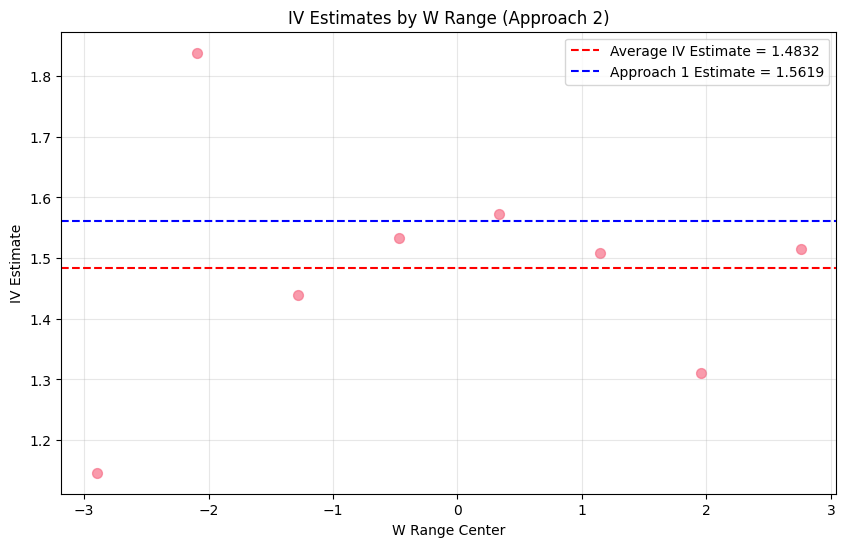

In [8]:
# Approach 2:

# Create narrow ranges of W
W_min, W_max = W.min(), W.max()
n_ranges = 10  # Number of ranges to create
range_width = (W_max - W_min) / n_ranges

print(f"W ranges from {W_min:.3f} to {W_max:.3f}")
print(f"Creating {n_ranges} ranges, each of width {range_width:.3f}")

iv_estimates_by_range = []
range_centers = []

for i in range(n_ranges):
    # Define range boundaries
    w_lower = W_min + i * range_width
    w_upper = W_min + (i + 1) * range_width
    range_center = (w_lower + w_upper) / 2
    
    # Select observations in this range
    in_range = (W >= w_lower) & (W < w_upper)
    
    if i == n_ranges - 1:  # Include the maximum value in the last range
        in_range = (W >= w_lower) & (W <= w_upper)
    
    n_obs_in_range = np.sum(in_range)
    
    if n_obs_in_range < 10:  # Skip ranges with too few observations
        continue
    
    # Calculate means within this range
    Z_range = Z[in_range]
    X_range = X[in_range]
    Y_range = Y[in_range]
    
    # Check if we have both Z=0 and Z=1 in this range
    has_Z0 = np.any(Z_range == 0)
    has_Z1 = np.any(Z_range == 1)
    
    if not (has_Z0 and has_Z1):
        continue
    
    # Calculate differences within this range
    Y_mean_Z1_range = Y_range[Z_range == 1].mean()
    Y_mean_Z0_range = Y_range[Z_range == 0].mean()
    X_mean_Z1_range = X_range[Z_range == 1].mean()
    X_mean_Z0_range = X_range[Z_range == 0].mean()
    
    delta_Y_range = Y_mean_Z1_range - Y_mean_Z0_range
    delta_X_range = X_mean_Z1_range - X_mean_Z0_range
    
    if abs(delta_X_range) > 1e-10:
        iv_estimate_range = delta_Y_range / delta_X_range
        iv_estimates_by_range.append(iv_estimate_range)
        range_centers.append(range_center)
        
        print(f"Range [{w_lower:.2f}, {w_upper:.2f}]: n={n_obs_in_range}, IV estimate={iv_estimate_range:.4f}")

# Average the IV estimates across ranges
if iv_estimates_by_range:
    iv_estimate_approach2 = np.mean(iv_estimates_by_range)
    iv_std_approach2 = np.std(iv_estimates_by_range)
    
    print(f"\nIV Estimate (Approach 2 - Average across ranges): {iv_estimate_approach2:.4f}")
    print(f"Standard deviation across ranges: {iv_std_approach2:.4f}")
    
    # Plot IV estimates by range
    plt.figure(figsize=(10, 6))
    plt.scatter(range_centers, iv_estimates_by_range, alpha=0.7, s=50)
    plt.axhline(y=iv_estimate_approach2, color='red', linestyle='--', 
                label=f'Average IV Estimate = {iv_estimate_approach2:.4f}')
    if 'iv_estimate_approach1' in locals():
        plt.axhline(y=iv_estimate_approach1, color='blue', linestyle='--', 
                    label=f'Approach 1 Estimate = {iv_estimate_approach1:.4f}')
    plt.xlabel('W Range Center')
    plt.ylabel('IV Estimate')
    plt.title('IV Estimates by W Range (Approach 2)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Could not calculate IV estimates for any ranges")


In [9]:
# COMPARISON AND VALIDATION

# Two-Stage Least Squares (2SLS) for comparison
print("\nTwo-Stage Least Squares (2SLS) for comparison:")

# First stage: regress X on Z (and W for completeness)
first_stage = LinearRegression()
first_stage.fit(Z.reshape(-1, 1), X)
X_predicted = first_stage.predict(Z.reshape(-1, 1))

# Second stage: regress Y on predicted X
second_stage = LinearRegression()
second_stage.fit(X_predicted.reshape(-1, 1), Y)
iv_estimate_2sls = second_stage.coef_[0]

print(f"2SLS IV Estimate: {iv_estimate_2sls:.4f}")

# Also calculate 2SLS with W as control
first_stage_with_W = LinearRegression()
first_stage_with_W.fit(np.column_stack([Z, W]), X)
X_predicted_with_W = first_stage_with_W.predict(np.column_stack([Z, W]))

second_stage_with_W = LinearRegression()
second_stage_with_W.fit(np.column_stack([X_predicted_with_W, W]), Y)
iv_estimate_2sls_with_W = second_stage_with_W.coef_[0]

print(f"2SLS IV Estimate (controlling for W): {iv_estimate_2sls_with_W:.4f}")

# Naive OLS estimate (biased due to confounding)
naive_ols = LinearRegression()
naive_ols.fit(X.reshape(-1, 1), Y)
naive_estimate = naive_ols.coef_[0]

print(f"Naive OLS Estimate (biased): {naive_estimate:.4f}")

# OLS controlling for W
ols_with_W = LinearRegression()
ols_with_W.fit(np.column_stack([X, W]), Y)
ols_estimate_with_W = ols_with_W.coef_[0]

print(f"OLS Estimate (controlling for W): {ols_estimate_with_W:.4f}")




Two-Stage Least Squares (2SLS) for comparison:
2SLS IV Estimate: 1.5619
2SLS IV Estimate (controlling for W): 1.5123
Naive OLS Estimate (biased): 1.5110
OLS Estimate (controlling for W): 1.4954


In [33]:
print("SUMMARY AND ANSWERS FOR 1 AND 2")


print("\nSummary of IV Estimates:")
if 'iv_estimate_approach1' in locals():
    print(f"Approach 1 (Simple difference): {iv_estimate_approach1:.4f}")
if 'iv_estimate_approach2' in locals():
    print(f"Approach 2 (Range averaging): {iv_estimate_approach2:.4f}")
print(f"2SLS method: {iv_estimate_2sls:.4f}")
print(f"2SLS with W control: {iv_estimate_2sls_with_W:.4f}")

print(f"\nFor comparison:")
print(f"Naive OLS (biased): {naive_estimate:.4f}")
print(f"OLS with W control: {ols_estimate_with_W:.4f}")

# Answer to Question 1
print(f"\nQUESTION 1 ANSWER:")
print(f"A) No - We don't need to know W to perform IV analysis")
print(f"The instrument Z allows us to estimate causal effects without observing confounders")

# Answer to Question 2
print(f"\nQUESTION 2 ANSWER:")
if 'iv_estimate_approach1' in locals():
    closest_option = None
    options = [0.5, 2, 1.5, 1]
    differences = [abs(iv_estimate_approach1 - opt) for opt in options]
    closest_idx = np.argmin(differences)
    closest_option = options[closest_idx]
    answer_q2 = chr(65 + closest_idx)
    
    print(f"The effect from Approach 1 is {iv_estimate_approach1:.4f}")
    print(f"This is closest to option {chr(65 + closest_idx)}) {closest_option}")

SUMMARY AND ANSWERS FOR 1 AND 2

Summary of IV Estimates:
Approach 1 (Simple difference): 1.5619
Approach 2 (Range averaging): 1.4832
2SLS method: 1.5619
2SLS with W control: 1.5123

For comparison:
Naive OLS (biased): 1.5110
OLS with W control: 1.4954

QUESTION 1 ANSWER:
A) No - We don't need to know W to perform IV analysis
The instrument Z allows us to estimate causal effects without observing confounders

QUESTION 2 ANSWER:
The effect from Approach 1 is 1.5619
This is closest to option C) 1.5


DIAGNOSTIC PLOTS


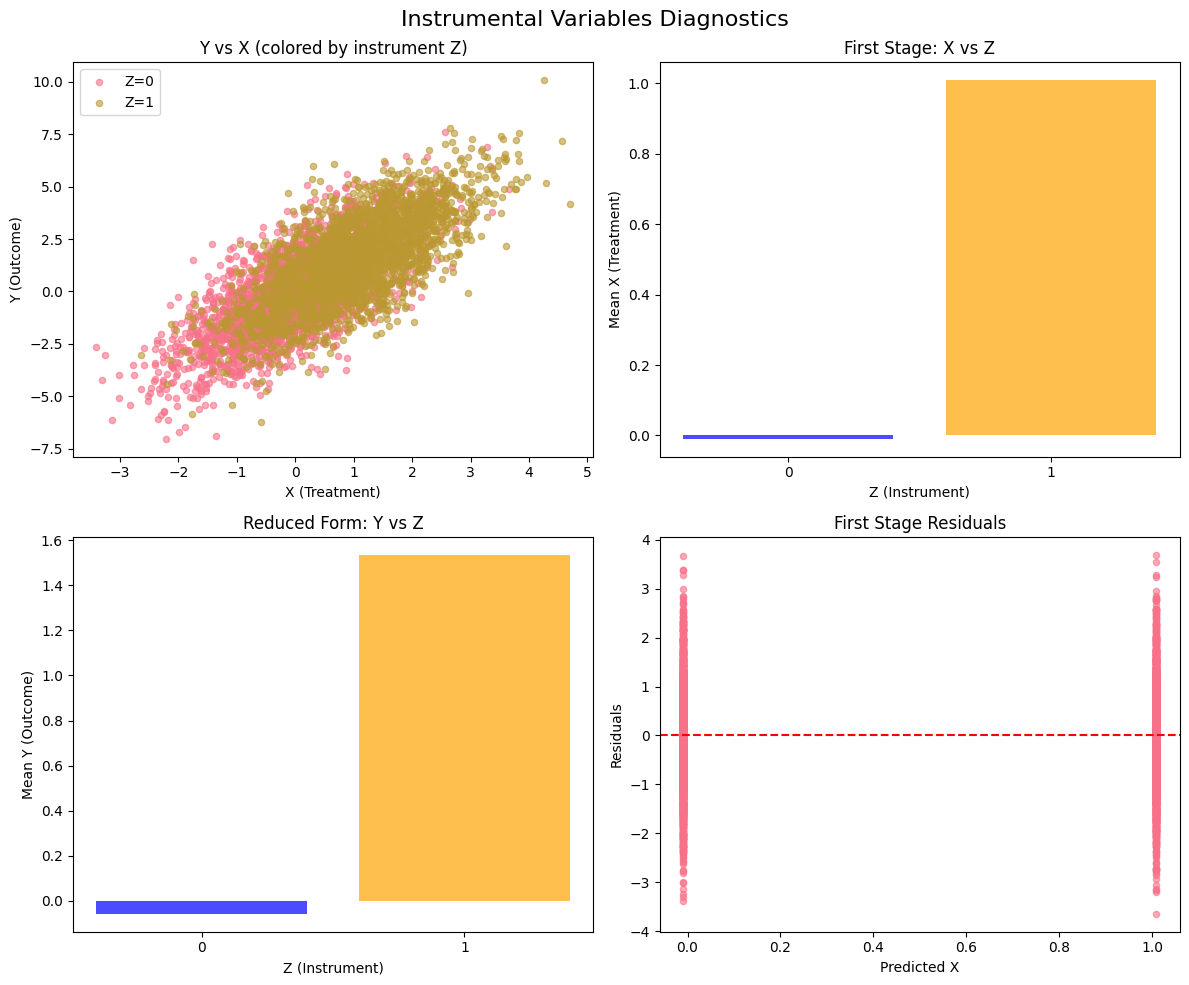


Instrument Strength:
First-stage F-statistic approximation: 1282.79
Strong instrument (F > 10)

Correlation between Z and X: 0.4519
This correlation should be strong for a good instrument.


In [11]:
print("DIAGNOSTIC PLOTS")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Instrumental Variables Diagnostics', fontsize=16)

# Plot 1: Y vs X, colored by Z
axes[0, 0].scatter(X[Z==0], Y[Z==0], alpha=0.6, label='Z=0', s=20)
axes[0, 0].scatter(X[Z==1], Y[Z==1], alpha=0.6, label='Z=1', s=20)
axes[0, 0].set_xlabel('X (Treatment)')
axes[0, 0].set_ylabel('Y (Outcome)')
axes[0, 0].set_title('Y vs X (colored by instrument Z)')
axes[0, 0].legend()

# Plot 2: First stage relationship (X vs Z)
z_vals = [0, 1]
x_means = [X[Z==0].mean(), X[Z==1].mean()]
axes[0, 1].bar(z_vals, x_means, alpha=0.7, color=['blue', 'orange'])
axes[0, 1].set_xlabel('Z (Instrument)')
axes[0, 1].set_ylabel('Mean X (Treatment)')
axes[0, 1].set_title('First Stage: X vs Z')
axes[0, 1].set_xticks([0, 1])

# Plot 3: Reduced form relationship (Y vs Z)
y_means = [Y[Z==0].mean(), Y[Z==1].mean()]
axes[1, 0].bar(z_vals, y_means, alpha=0.7, color=['blue', 'orange'])
axes[1, 0].set_xlabel('Z (Instrument)')
axes[1, 0].set_ylabel('Mean Y (Outcome)')
axes[1, 0].set_title('Reduced Form: Y vs Z')
axes[1, 0].set_xticks([0, 1])

# Plot 4: Residuals from first stage
first_stage_residuals = X - X_predicted
axes[1, 1].scatter(X_predicted, first_stage_residuals, alpha=0.6, s=20)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted X')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('First Stage Residuals')

plt.tight_layout()
plt.show()

# Final instrument strength check
first_stage_f_stat = (np.corrcoef(Z, X)[0, 1]**2) * (len(Z) - 2) / (1 - np.corrcoef(Z, X)[0, 1]**2)
print(f"\nInstrument Strength:")
print(f"First-stage F-statistic approximation: {first_stage_f_stat:.2f}")
if first_stage_f_stat > 10:
    print("Strong instrument (F > 10)")
else:
    print("Weak instrument (F < 10)")

print(f"\nCorrelation between Z and X: {np.corrcoef(Z, X)[0, 1]:.4f}")
print(f"This correlation should be strong for a good instrument.")

# Section 2

In [13]:
# Load Dataset A
dataset_a = pd.read_csv('homework_4.2.a.csv')
print("\nDATASET A (homework_4.2.a.csv):")
print(f"Shape: {dataset_a.shape}")
print("\nFirst few rows:")
print(dataset_a.head())
print("\nSummary statistics:")
print(dataset_a.describe())

# Load Dataset B  
dataset_b = pd.read_csv('homework_4.2.b.csv')
print("\nDATASET B (homework_4.2.b.csv):")
print(f"Shape: {dataset_b.shape}")
print("\nFirst few rows:")
print(dataset_b.head())
print("\nSummary statistics:")
print(dataset_b.describe())

# Extract variables with unique names
# Dataset A
X_a = dataset_a['X'].values
Y_a = dataset_a['Y'].values

# Dataset B
X2_b = dataset_b['X2'].values  
Y2_b = dataset_b['Y2'].values

# Check ranges around cutoff of 80
cutoff = 80

print(f"\nCUTOFF ANALYSIS (cutoff = {cutoff}):")
print(f"Dataset A - X range: [{X_a.min():.2f}, {X_a.max():.2f}]")
print(f"Dataset B - X2 range: [{X2_b.min():.2f}, {X2_b.max():.2f}]")

# Check how many observations are near the cutoff
window = 10  # Look at ±10 around cutoff
print(f"\nObservations within ±{window} of cutoff ({cutoff}):")
near_cutoff_a = np.sum((X_a >= cutoff - window) & (X_a <= cutoff + window))
near_cutoff_b = np.sum((X2_b >= cutoff - window) & (X2_b <= cutoff + window))
print(f"Dataset A: {near_cutoff_a} observations")
print(f"Dataset B: {near_cutoff_b} observations")


DATASET A (homework_4.2.a.csv):
Shape: (100000, 3)

First few rows:
   Unnamed: 0          X  Y
0           0  81.822339  1
1           1  92.487870  0
2           2  85.372460  0
3           3  78.828025  0
4           4  75.807080  1

Summary statistics:
          Unnamed: 0              X              Y
count  100000.000000  100000.000000  100000.000000
mean    49999.500000      79.914828       0.452830
std     28867.657797       9.794797       0.497773
min         0.000000      36.832254       0.000000
25%     24999.750000      73.251725       0.000000
50%     49999.500000      80.016893       0.000000
75%     74999.250000      86.710243       1.000000
max     99999.000000     100.000000       1.000000

DATASET B (homework_4.2.b.csv):
Shape: (100000, 3)

First few rows:
   Unnamed: 0         X2  Y2
0           0  76.643034   1
1           1  87.743397   1
2           2  81.639469   1
3           3  73.740485   0
4           4  90.480268   1

Summary statistics:
          Unnamed: 

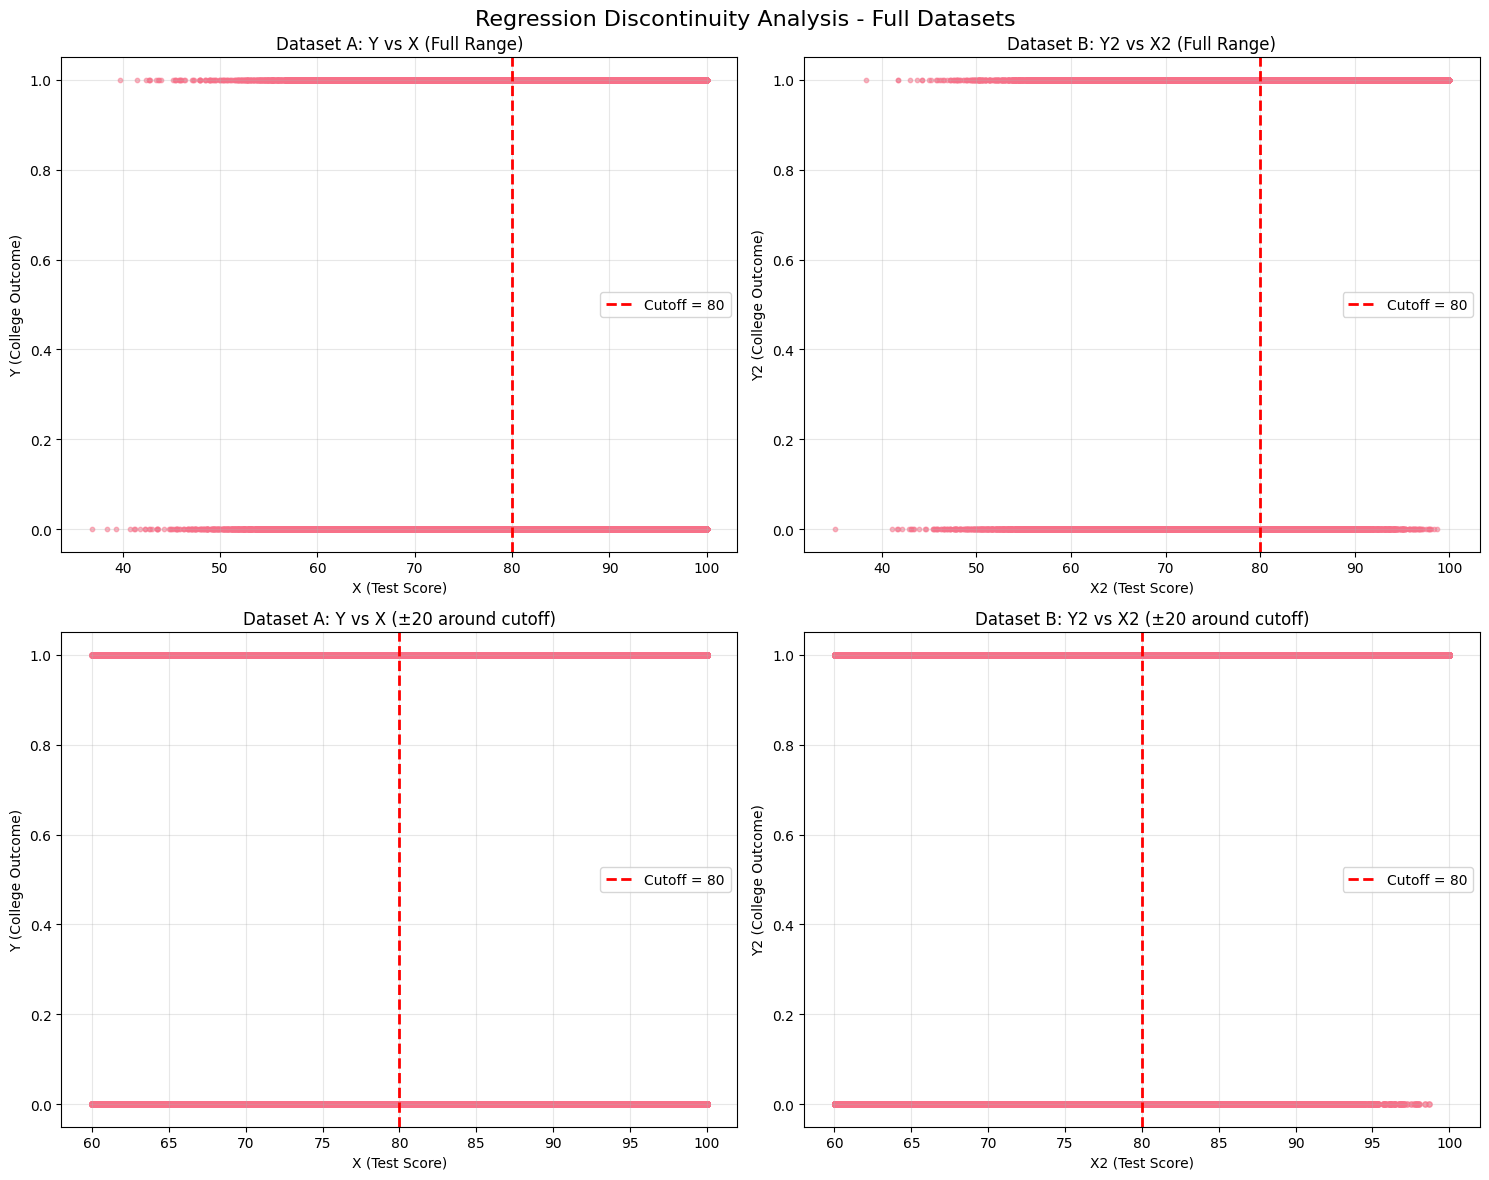

In [14]:
# VISUAL ANALYSIS OF THE DATASETS

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Regression Discontinuity Analysis - Full Datasets', fontsize=16)

# Dataset A - Full view
axes[0, 0].scatter(X_a, Y_a, alpha=0.5, s=10)
axes[0, 0].axvline(x=cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff}')
axes[0, 0].set_xlabel('X (Test Score)')
axes[0, 0].set_ylabel('Y (College Outcome)')
axes[0, 0].set_title('Dataset A: Y vs X (Full Range)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dataset B - Full view
axes[0, 1].scatter(X2_b, Y2_b, alpha=0.5, s=10)
axes[0, 1].axvline(x=cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff}')
axes[0, 1].set_xlabel('X2 (Test Score)')
axes[0, 1].set_ylabel('Y2 (College Outcome)')
axes[0, 1].set_title('Dataset B: Y2 vs X2 (Full Range)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Dataset A - Zoomed around cutoff
zoom_window = 20
in_window_a = (X_a >= cutoff - zoom_window) & (X_a <= cutoff + zoom_window)
axes[1, 0].scatter(X_a[in_window_a], Y_a[in_window_a], alpha=0.7, s=15)
axes[1, 0].axvline(x=cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff}')
axes[1, 0].set_xlabel('X (Test Score)')
axes[1, 0].set_ylabel('Y (College Outcome)')
axes[1, 0].set_title(f'Dataset A: Y vs X (±{zoom_window} around cutoff)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Dataset B - Zoomed around cutoff
in_window_b = (X2_b >= cutoff - zoom_window) & (X2_b <= cutoff + zoom_window)
axes[1, 1].scatter(X2_b[in_window_b], Y2_b[in_window_b], alpha=0.7, s=15)
axes[1, 1].axvline(x=cutoff, color='red', linestyle='--', linewidth=2, label=f'Cutoff = {cutoff}')
axes[1, 1].set_xlabel('X2 (Test Score)')
axes[1, 1].set_ylabel('Y2 (College Outcome)')
axes[1, 1].set_title(f'Dataset B: Y2 vs X2 (±{zoom_window} around cutoff)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANALYSIS AROUND THE CUTOFF

In [19]:
def analyze_regression_discontinuity(X, Y, cutoff, dataset_name):
    """Analyze regression discontinuity around cutoff"""
    print(f"REGRESSION DISCONTINUITY ANALYSIS - {dataset_name}")
    print(f"{'-'*50}")
    
    # Create treatment indicator
    treatment = (X >= cutoff).astype(int)
    
    # Center X around cutoff
    X_centered = X - cutoff
    
    # Separate before and after cutoff
    before_cutoff = X < cutoff
    after_cutoff = X >= cutoff
    
    print(f"Observations before cutoff: {np.sum(before_cutoff)}")
    print(f"Observations after cutoff: {np.sum(after_cutoff)}")
    
    if np.sum(before_cutoff) > 0 and np.sum(after_cutoff) > 0:
        # Analyze slopes before and after
        if np.sum(before_cutoff) > 1:
            slope_before = LinearRegression().fit(X[before_cutoff].reshape(-1, 1), Y[before_cutoff]).coef_[0]
            intercept_before = LinearRegression().fit(X[before_cutoff].reshape(-1, 1), Y[before_cutoff]).intercept_
            print(f"Slope before cutoff: {slope_before:.6f}")
        else:
            slope_before = np.nan
            intercept_before = np.nan
            print("Not enough observations before cutoff")
            
        if np.sum(after_cutoff) > 1:
            slope_after = LinearRegression().fit(X[after_cutoff].reshape(-1, 1), Y[after_cutoff]).coef_[0]
            intercept_after = LinearRegression().fit(X[after_cutoff].reshape(-1, 1), Y[after_cutoff]).intercept_
            print(f"Slope after cutoff: {slope_after:.6f}")
        else:
            slope_after = np.nan
            intercept_after = np.nan
            print("Not enough observations after cutoff")
        
        # Mean Y values just before and after cutoff
        window_size = 5  # Look at observations within ±5 of cutoff
        near_before = (X >= cutoff - window_size) & (X < cutoff)
        near_after = (X >= cutoff) & (X <= cutoff + window_size)
        
        if np.sum(near_before) > 0 and np.sum(near_after) > 0:
            mean_Y_before = Y[near_before].mean()
            mean_Y_after = Y[near_after].mean()
            discontinuity = mean_Y_after - mean_Y_before
            
            print(f"\nMean Y just before cutoff (±{window_size}): {mean_Y_before:.6f}")
            print(f"Mean Y just after cutoff (±{window_size}): {mean_Y_after:.6f}")
            print(f"Discontinuity at cutoff: {discontinuity:.6f}")
        
        # RD regression with linear terms
        if len(X) > 10:  # Need sufficient observations
            # Model: Y = α + β₁(X-c) + β₂*Treatment + β₃*Treatment*(X-c) + ε
            X_centered = X - cutoff
            interaction = treatment * X_centered
            
            # Create design matrix
            design_matrix = np.column_stack([
                np.ones(len(X)),           # Intercept
                X_centered,                # Linear term
                treatment,                 # Treatment indicator  
                interaction                # Interaction term
            ])
            
            # Fit RD model
            rd_model = LinearRegression().fit(design_matrix, Y)
            coeffs = rd_model.coef_
            
            print(f"\nRD Regression Results:")
            print(f"Intercept (α): {rd_model.intercept_:.6f}")
            print(f"Linear term before cutoff (β₁): {coeffs[1]:.6f}")
            print(f"Discontinuity at cutoff (β₂): {coeffs[2]:.6f}")
            print(f"Change in slope after cutoff (β₃): {coeffs[3]:.6f}")
            print(f"Effective slope after cutoff: {coeffs[1] + coeffs[3]:.6f}")
            
            return {
                'slope_before': coeffs[1],
                'slope_after': coeffs[1] + coeffs[3],
                'discontinuity': coeffs[2],
                'slope_change': coeffs[3],
                'has_linear_relationship': abs(coeffs[1]) > 0.001 or abs(coeffs[1] + coeffs[3]) > 0.001
            }
    
    return None

# Analyze both datasets
results_a = analyze_regression_discontinuity(X_a, Y_a, cutoff, "DATASET A")
print("\n")
results_b = analyze_regression_discontinuity(X2_b, Y2_b, cutoff, "DATASET B")


REGRESSION DISCONTINUITY ANALYSIS - DATASET A
--------------------------------------------------
Observations before cutoff: 49926
Observations after cutoff: 50074
Slope before cutoff: 0.000224
Slope after cutoff: 0.000161

Mean Y just before cutoff (±5): 0.304706
Mean Y just after cutoff (±5): 0.601258
Discontinuity at cutoff: 0.296552

RD Regression Results:
Intercept (α): 0.304997
Linear term before cutoff (β₁): 0.000224
Discontinuity at cutoff (β₂): 0.295757
Change in slope after cutoff (β₃): -0.000063
Effective slope after cutoff: 0.000161


REGRESSION DISCONTINUITY ANALYSIS - DATASET B
--------------------------------------------------
Observations before cutoff: 50068
Observations after cutoff: 49932
Slope before cutoff: 0.010217
Slope after cutoff: 0.005009

Mean Y just before cutoff (±5): 0.673491
Mean Y just after cutoff (±5): 0.912132
Discontinuity at cutoff: 0.238641

RD Regression Results:
Intercept (α): 0.702345
Linear term before cutoff (β₁): 0.010217
Discontinuity at cu

ANALYSIS AT CUTOFF = 80

In [20]:
# Look at a narrow window around 80
narrow_window = 15

# Dataset A analysis
print(f"\nDATASET A - Analysis within ±{narrow_window} of cutoff:")
window_a = (X_a >= cutoff - narrow_window) & (X_a <= cutoff + narrow_window)
if np.sum(window_a) > 0:
    X_window_a = X_a[window_a]
    Y_window_a = Y_a[window_a]
    
    before_a = X_window_a < cutoff
    after_a = X_window_a >= cutoff
    
    print(f"Observations in window: {len(X_window_a)}")
    print(f"Before cutoff: {np.sum(before_a)}")
    print(f"After cutoff: {np.sum(after_a)}")
    
    if np.sum(before_a) > 1 and np.sum(after_a) > 1:
        # Fit linear models
        model_before_a = LinearRegression().fit(X_window_a[before_a].reshape(-1, 1), Y_window_a[before_a])
        model_after_a = LinearRegression().fit(X_window_a[after_a].reshape(-1, 1), Y_window_a[after_a])
        
        slope_before_a = model_before_a.coef_[0]
        slope_after_a = model_after_a.coef_[0]
        
        print(f"Slope before cutoff: {slope_before_a:.6f}")
        print(f"Slope after cutoff: {slope_after_a:.6f}")
        print(f"Slope change: {slope_after_a - slope_before_a:.6f}")
        
        # Predict Y at cutoff from both sides
        Y_pred_before_a = model_before_a.predict([[cutoff]])[0]
        Y_pred_after_a = model_after_a.predict([[cutoff]])[0]
        discontinuity_a = Y_pred_after_a - Y_pred_before_a
        
        print(f"Predicted Y just before cutoff: {Y_pred_before_a:.6f}")
        print(f"Predicted Y just after cutoff: {Y_pred_after_a:.6f}")
        print(f"Discontinuity: {discontinuity_a:.6f}")

# Dataset B analysis
print(f"\nDATASET B - Analysis within ±{narrow_window} of cutoff:")
window_b = (X2_b >= cutoff - narrow_window) & (X2_b <= cutoff + narrow_window)
if np.sum(window_b) > 0:
    X_window_b = X2_b[window_b]
    Y_window_b = Y2_b[window_b]
    
    before_b = X_window_b < cutoff
    after_b = X_window_b >= cutoff
    
    print(f"Observations in window: {len(X_window_b)}")
    print(f"Before cutoff: {np.sum(before_b)}")
    print(f"After cutoff: {np.sum(after_b)}")
    
    if np.sum(before_b) > 1 and np.sum(after_b) > 1:
        # Fit linear models
        model_before_b = LinearRegression().fit(X_window_b[before_b].reshape(-1, 1), Y_window_b[before_b])
        model_after_b = LinearRegression().fit(X_window_b[after_b].reshape(-1, 1), Y_window_b[after_b])
        
        slope_before_b = model_before_b.coef_[0]
        slope_after_b = model_after_b.coef_[0]
        
        print(f"Slope before cutoff: {slope_before_b:.6f}")
        print(f"Slope after cutoff: {slope_after_b:.6f}")
        print(f"Slope change: {slope_after_b - slope_before_b:.6f}")
        
        # Predict Y at cutoff from both sides
        Y_pred_before_b = model_before_b.predict([[cutoff]])[0]
        Y_pred_after_b = model_after_b.predict([[cutoff]])[0]
        discontinuity_b = Y_pred_after_b - Y_pred_before_b
        
        print(f"Predicted Y just before cutoff: {Y_pred_before_b:.6f}")
        print(f"Predicted Y just after cutoff: {Y_pred_after_b:.6f}")
        print(f"Discontinuity: {discontinuity_b:.6f}")


DATASET A - Analysis within ±15 of cutoff:
Observations in window: 86592
Before cutoff: 43213
After cutoff: 43379
Slope before cutoff: -0.000067
Slope after cutoff: -0.000020
Slope change: 0.000047
Predicted Y just before cutoff: 0.303660
Predicted Y just after cutoff: 0.601821
Discontinuity: 0.298161

DATASET B - Analysis within ±15 of cutoff:
Observations in window: 86638
Before cutoff: 43346
After cutoff: 43292
Slope before cutoff: 0.010388
Slope after cutoff: 0.004741
Slope change: -0.005647
Predicted Y just before cutoff: 0.703150
Predicted Y just after cutoff: 0.900723
Discontinuity: 0.197573


VISUALIZATION WITH LINEAR FIT LINES

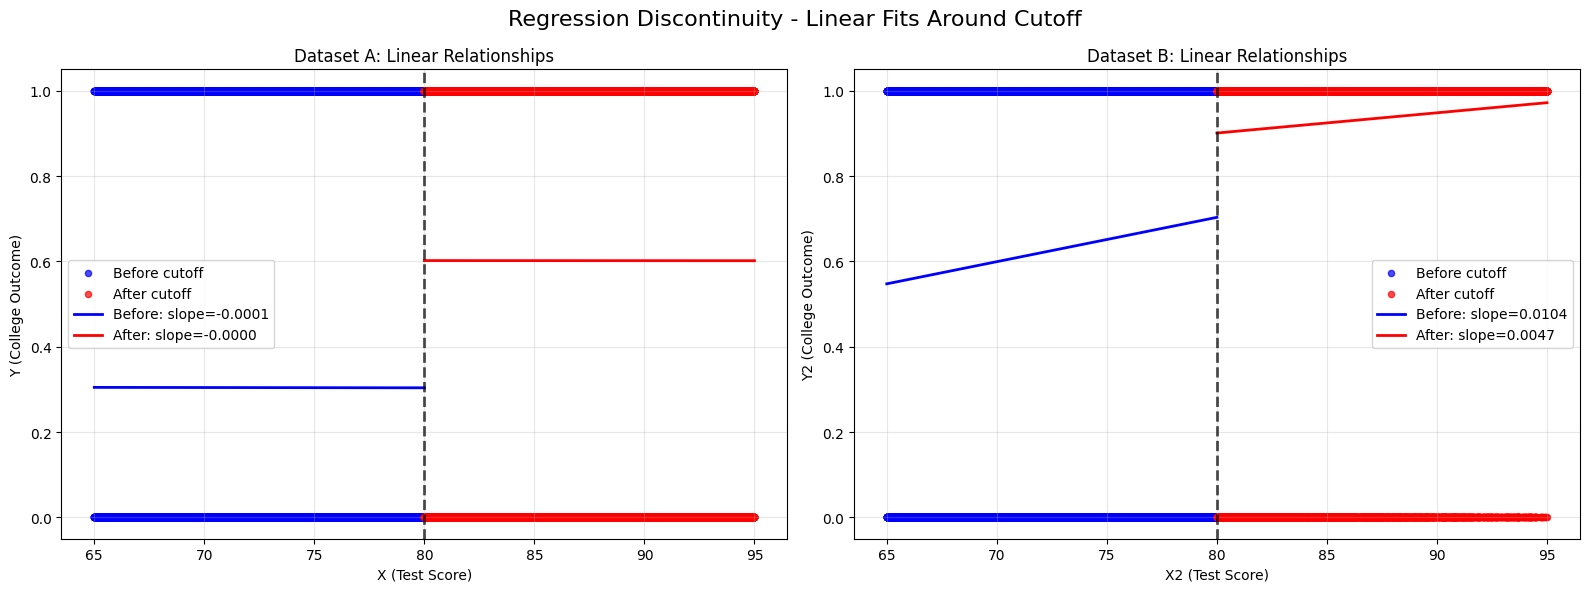

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Regression Discontinuity - Linear Fits Around Cutoff', fontsize=16)

# Dataset A detailed plot
if 'X_window_a' in locals() and len(X_window_a) > 0:
    before_mask_a = X_window_a < cutoff
    after_mask_a = X_window_a >= cutoff
    
    axes[0].scatter(X_window_a[before_mask_a], Y_window_a[before_mask_a], 
                   alpha=0.7, color='blue', label='Before cutoff', s=20)
    axes[0].scatter(X_window_a[after_mask_a], Y_window_a[after_mask_a], 
                   alpha=0.7, color='red', label='After cutoff', s=20)
    
    # Plot fitted lines if we have models
    if 'model_before_a' in locals() and 'model_after_a' in locals():
        x_before = np.linspace(X_window_a[before_mask_a].min(), cutoff, 100)
        x_after = np.linspace(cutoff, X_window_a[after_mask_a].max(), 100)
        
        y_before = model_before_a.predict(x_before.reshape(-1, 1))
        y_after = model_after_a.predict(x_after.reshape(-1, 1))
        
        axes[0].plot(x_before, y_before, color='blue', linestyle='-', linewidth=2, 
                    label=f'Before: slope={slope_before_a:.4f}')
        axes[0].plot(x_after, y_after, color='red', linestyle='-', linewidth=2, 
                    label=f'After: slope={slope_after_a:.4f}')

axes[0].axvline(x=cutoff, color='black', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_xlabel('X (Test Score)')
axes[0].set_ylabel('Y (College Outcome)')
axes[0].set_title('Dataset A: Linear Relationships')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dataset B detailed plot
if 'X_window_b' in locals() and len(X_window_b) > 0:
    before_mask_b = X_window_b < cutoff
    after_mask_b = X_window_b >= cutoff
    
    axes[1].scatter(X_window_b[before_mask_b], Y_window_b[before_mask_b], 
                   alpha=0.7, color='blue', label='Before cutoff', s=20)
    axes[1].scatter(X_window_b[after_mask_b], Y_window_b[after_mask_b], 
                   alpha=0.7, color='red', label='After cutoff', s=20)
    
    # Plot fitted lines if we have models
    if 'model_before_b' in locals() and 'model_after_b' in locals():
        x_before = np.linspace(X_window_b[before_mask_b].min(), cutoff, 100)
        x_after = np.linspace(cutoff, X_window_b[after_mask_b].max(), 100)
        
        y_before = model_before_b.predict(x_before.reshape(-1, 1))
        y_after = model_after_b.predict(x_after.reshape(-1, 1))
        
        axes[1].plot(x_before, y_before, color='blue', linestyle='-', linewidth=2, 
                    label=f'Before: slope={slope_before_b:.4f}')
        axes[1].plot(x_after, y_after, color='red', linestyle='-', linewidth=2, 
                    label=f'After: slope={slope_after_b:.4f}')

axes[1].axvline(x=cutoff, color='black', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_xlabel('X2 (Test Score)')
axes[1].set_ylabel('Y2 (College Outcome)')
axes[1].set_title('Dataset B: Linear Relationships')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## QUESTION 3

In [22]:
print("\nQUESTION 3: Which dataset seems most likely to involve a nonzero linear term?")
print("Looking for evidence of linear relationships before and after the cutoff...")

# Determine which dataset has stronger linear relationships
has_linear_a = False
has_linear_b = False

if 'slope_before_a' in locals() and 'slope_after_a' in locals():
    has_linear_a = abs(slope_before_a) > 0.01 or abs(slope_after_a) > 0.01
    print(f"\nDataset A slopes: Before={slope_before_a:.4f}, After={slope_after_a:.4f}")
    print(f"Dataset A has meaningful linear terms: {has_linear_a}")

if 'slope_before_b' in locals() and 'slope_after_b' in locals():
    has_linear_b = abs(slope_before_b) > 0.01 or abs(slope_after_b) > 0.01
    print(f"\nDataset B slopes: Before={slope_before_b:.4f}, After={slope_after_b:.4f}")
    print(f"Dataset B has meaningful linear terms: {has_linear_b}")

if has_linear_a and not has_linear_b:
    answer_q3 = "A"
    selected_dataset = "A"
elif has_linear_b and not has_linear_a:
    answer_q3 = "B"
    selected_dataset = "B"
elif has_linear_a and has_linear_b:
    # Choose the one with stronger linear relationship
    if 'slope_before_a' in locals() and 'slope_before_b' in locals():
        strength_a = max(abs(slope_before_a), abs(slope_after_a))
        strength_b = max(abs(slope_before_b), abs(slope_after_b))
        if strength_a > strength_b:
            answer_q3 = "A"
            selected_dataset = "A"
        else:
            answer_q3 = "B"
            selected_dataset = "B"
    else:
        answer_q3 = "A"  # Default
        selected_dataset = "A"
else:
    answer_q3 = "A"  # Default if neither shows clear linear relationship
    selected_dataset = "A"

print(f"\nANSWER TO QUESTION 3: {answer_q3}) Dataset {answer_q3.lower()}")


QUESTION 3: Which dataset seems most likely to involve a nonzero linear term?
Looking for evidence of linear relationships before and after the cutoff...

Dataset A slopes: Before=-0.0001, After=-0.0000
Dataset A has meaningful linear terms: False

Dataset B slopes: Before=0.0104, After=0.0047
Dataset B has meaningful linear terms: True

ANSWER TO QUESTION 3: B) Dataset b


## QUESTIONS 4 AND 5

In [23]:
# Questions 4 and 5 about the selected dataset
if selected_dataset == "A":
    if 'slope_before_a' in locals() and 'slope_after_a' in locals():
        slope_before_selected = slope_before_a
        slope_after_selected = slope_after_a
        
        print(f"\nQUESTION 4: Is Y's slope higher or lower after the cutoff compared with before?")
        print(f"Slope before cutoff: {slope_before_selected:.6f}")
        print(f"Slope after cutoff: {slope_after_selected:.6f}")
        
        if slope_after_selected > slope_before_selected:
            answer_q4 = "A"
            print(f"ANSWER TO QUESTION 4: A) Higher")
        else:
            answer_q4 = "B"
            print(f"ANSWER TO QUESTION 4: B) Lower")
        
        print(f"\nQUESTION 5: Is Y increasing or decreasing before the cutoff?")
        if slope_before_selected > 0:
            answer_q5 = "B"
            print(f"ANSWER TO QUESTION 5: B) Increasing")
        else:
            answer_q5 = "A"
            print(f"ANSWER TO QUESTION 5: A) Decreasing")

elif selected_dataset == "B":
    if 'slope_before_b' in locals() and 'slope_after_b' in locals():
        slope_before_selected = slope_before_b
        slope_after_selected = slope_after_b
        
        print(f"\nQUESTION 4: Is Y's slope higher or lower after the cutoff compared with before?")
        print(f"Slope before cutoff: {slope_before_selected:.6f}")
        print(f"Slope after cutoff: {slope_after_selected:.6f}")
        
        if slope_after_selected > slope_before_selected:
            answer_q4 = "A"
            print(f"ANSWER TO QUESTION 4: A) Higher")
        else:
            answer_q4 = "B"
            print(f"ANSWER TO QUESTION 4: B) Lower")
        
        print(f"\nQUESTION 5: Is Y increasing or decreasing before the cutoff?")
        if slope_before_selected > 0:
            answer_q5 = "B"
            print(f"ANSWER TO QUESTION 5: B) Increasing")
        else:
            answer_q5 = "A"
            print(f"ANSWER TO QUESTION 5: A) Decreasing")


QUESTION 4: Is Y's slope higher or lower after the cutoff compared with before?
Slope before cutoff: 0.010388
Slope after cutoff: 0.004741
ANSWER TO QUESTION 4: B) Lower

QUESTION 5: Is Y increasing or decreasing before the cutoff?
ANSWER TO QUESTION 5: B) Increasing


In [34]:
print("SUMMARY OF ANSWERS")
print(f"{'-'*40}")
print(f"Question 1: A")
print(f"Question 2: {answer_q2}")
print(f"Question 3: {answer_q3}")
if 'answer_q4' in locals():
    print(f"Question 4: {answer_q4}")
if 'answer_q5' in locals():
    print(f"Question 5: {answer_q5}")

SUMMARY OF ANSWERS
----------------------------------------
Question 1: A
Question 2: C
Question 3: B
Question 4: B
Question 5: B
